In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import GridSearchCV

Text(0.5, 1.0, 'SARAL - Brouwer Mean Motion')

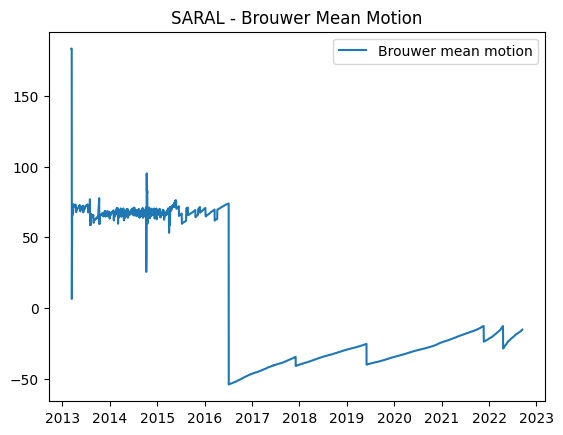

In [3]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_SARAL.csv"

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path, index_col = 0, parse_dates = True)

# Creating a dataframe with only the Brouwer Mean Motion
df_bmm = df[["Brouwer mean motion"]]

# Centering and scaling the data
df_bmm = (df_bmm - df_bmm.mean()) * 1e7

# Plotting the Brouwer Mean Motion
sns.lineplot(data = df_bmm)
plt.title("SARAL - Brouwer Mean Motion")

In [131]:
""" start_date = pd.to_datetime("2017")
end_date = pd.to_datetime("2022")

# Filtering maneuvers based on the date range
df_bmm = df_bmm[df_bmm.index >= start_date]
df_bmm = df_bmm[df_bmm.index <= end_date]

df_bmm """

' start_date = pd.to_datetime("2017")\nend_date = pd.to_datetime("2022")\n\n# Filtering maneuvers based on the date range\ndf_bmm = df_bmm[df_bmm.index >= start_date]\ndf_bmm = df_bmm[df_bmm.index <= end_date]\n\ndf_bmm '

In [4]:
NUM_LAG_FEATURES = 3

# Creating features and labels
df_bmm_y = df_bmm.copy()
df_bmm_x = df_bmm.shift(1)

# Renaming the 1st Lag feature
df_bmm_x = df_bmm_x.rename(columns={"Brouwer mean motion": "bmm_lag_1"})

# Adding the rest of the lag features based on the number of lags
for lag in range(2,NUM_LAG_FEATURES + 1):
    df_bmm_x[f"bmm_lag_{lag}"] = df_bmm.shift(lag)

In [5]:
df_bmm_x

,bmm_lag_1,bmm_lag_2,bmm_lag_3
2013-03-10 13:13:33.964320,NaN,NaN,NaN
2013-03-11 22:45:10.058975,183.347553,NaN,NaN
2013-03-13 01:34:26.835167,183.547089,183.347553,NaN
2013-03-14 02:43:30.192095,182.319672,183.547089,183.347553
2013-03-15 18:57:49.375584,6.448535,182.319672,183.547089
...,...,...,...
2022-09-10 11:47:30.833376,-15.769776,-15.913966,-15.964214
2022-09-11 12:56:41.592191,-15.683261,-15.769776,-15.913966
2022-09-12 12:25:15.614976,-15.583821,-15.683261,-15.769776
2022-09-13 03:30:46.060415,-15.440941,-15.583821,-15.683261


In [6]:
df_bmm_y

,Brouwer mean motion
2013-03-10 13:13:33.964320,183.347553
2013-03-11 22:45:10.058975,183.547089
2013-03-13 01:34:26.835167,182.319672
2013-03-14 02:43:30.192095,6.448535
2013-03-15 18:57:49.375584,66.248920
...,...
2022-09-10 11:47:30.833376,-15.683261
2022-09-11 12:56:41.592191,-15.583821
2022-09-12 12:25:15.614976,-15.440941
2022-09-13 03:30:46.060415,-15.414908


In [7]:
# Removing rows with NaN values
df_bmm_y = df_bmm_y.iloc[NUM_LAG_FEATURES:]
df_bmm_x = df_bmm_x.iloc[NUM_LAG_FEATURES:]

In [8]:
# Train Test data splitting based on date
SPLIT_DATE = "2019-01-20"
df_bmm_x_train = df_bmm_x[:SPLIT_DATE]
df_bmm_x_test = df_bmm_x[SPLIT_DATE:]
df_bmm_y_train = df_bmm_y[:SPLIT_DATE]
df_bmm_y_test = df_bmm_y[SPLIT_DATE:]

In [9]:
# Getting the training data percentage
train_percentage = df_bmm_y_train.size / (df_bmm_y_train.size + df_bmm_y_test.size)
print(round(train_percentage*100,2))

59.85


In [10]:
# Getting the testing data percentage
test_percentage = df_bmm_y_test.size / (df_bmm_y_train.size + df_bmm_y_test.size)
print(round(test_percentage*100,2))

40.15


In [139]:
# Using grid search to find the best hyperparameters
def grid_search_xgboost(X_train, y_train, cv = 5, verbose = 1):
    param_grid = {
        'n_estimators': [100,1000,1500,2000],
        'max_depth': [5,7,9],
        'learning_rate': [0.01,0.001,0.1],
        'colsample_bytree': [0.5,0.8,1],
        'min_child_weight': [3,5,7]
    }

    xgb_model = XGBRegressor(random_state = 25)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=cv,
        verbose=verbose,
        n_jobs=1
    )

    grid_search.fit(X_train,y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("Best Parameters Found:")
    print(best_params)

    return best_model, best_params

best_xgb_model, best_xgb_params = grid_search_xgboost(df_bmm_x_train,df_bmm_y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters Found:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100}


In [11]:
# Creating the XGBoost regressor with early stopping to avoid overfitting
xgb_regressor = XGBRegressor(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    colsample_bytree = 0.8,
    min_child_weight = 7,
    #subsample = 1,
    eval_metric = 'mae',
    early_stopping_rounds = 10
)

In [12]:
# Fitting the XGBoost model
xgb_regressor.fit(
    df_bmm_x_train,
    df_bmm_y_train,
    eval_set = [(df_bmm_x_train,df_bmm_y_train), (df_bmm_x_test,df_bmm_y_test)],
    verbose = True
)

[0]	validation_0-mae:48.30693	validation_1-mae:41.65363
[1]	validation_0-mae:43.52861	validation_1-mae:41.50960
[2]	validation_0-mae:39.22037	validation_1-mae:40.33362
[3]	validation_0-mae:35.34604	validation_1-mae:39.28847
[4]	validation_0-mae:31.85595	validation_1-mae:38.35143
[5]	validation_0-mae:28.71359	validation_1-mae:39.14458
[6]	validation_0-mae:25.88312	validation_1-mae:38.31328
[7]	validation_0-mae:23.33735	validation_1-mae:37.57548
[8]	validation_0-mae:21.04562	validation_1-mae:38.16663
[9]	validation_0-mae:18.98097	validation_1-mae:37.51530
[10]	validation_0-mae:17.12149	validation_1-mae:36.97253
[11]	validation_0-mae:15.44832	validation_1-mae:36.49064
[12]	validation_0-mae:13.94346	validation_1-mae:36.05472
[13]	validation_0-mae:12.58670	validation_1-mae:36.40478
[14]	validation_0-mae:11.36689	validation_1-mae:36.71487
[15]	validation_0-mae:10.26863	validation_1-mae:36.68406
[16]	validation_0-mae:9.28042	validation_1-mae:36.94849
[17]	validation_0-mae:8.38906	validation_1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

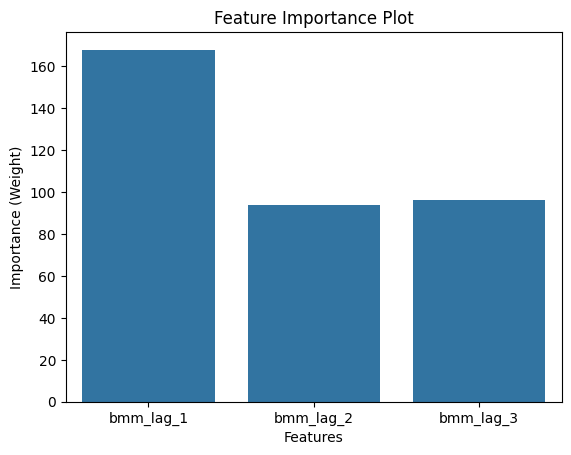

In [13]:
# Generating the feature importance plot
feature_importance = xgb_regressor.get_booster().get_score(importance_type = "weight")
sns.barplot(x = list(feature_importance.keys()), y = list(feature_importance.values()))
plt.xlabel("Features")
plt.ylabel("Importance (Weight)")
plt.title("Feature Importance Plot")
plt.show()

In [14]:
# Defining the format of the maneuver text file
columns_widths = [
    (0,5),      # Satellite Name
    (6,10),     # Begining of manueuver year    
    (11,14),    # Begining of manueuver day       
    (15,17),    # Begining of manueuver hour 
    (18,20),    # Begining of manueuver minute 
    (21,25),    # End of manueuver year 
    (26,29),    # End of manueuver day 
    (30,32),    # End of manueuver hour 
    (33,35),    # End of manueuver minute 
    (36,39),    # Manuever type
    (40,43),    # Manuever parameter type
    (44,45)     # Number of burns
]

# Function to parse each line based on column widths defined
def parse_line(line):
    data = [
        line[start:end].strip()
        for start, end in columns_widths
    ]
    return data

# Function to convert start and end maneuver to datetime
def convert_to_datetime(row):
    start_date = datetime.strptime(f"{row['Start_Year']} {row['Start_Day']} {row['Start_Hour']} {row['Start_Minute']}", "%Y %j %H %M")
    end_date = datetime.strptime(f"{row['End_Year']} {row['End_Day']} {row['End_Hour']} {row['End_Minute']}", "%Y %j %H %M")
    return start_date, end_date

# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/s3aman.txt'

# Reading the text file into a list of lines
with open(maneuver_file_path, 'r') as txt_file:
    lines = txt_file.readlines()

# Parsing each line into a list of values
parsed_data = [parse_line(line) for line in lines]

# Defining the column names
column_names = [
    'Satellite', 'Start_Year', 'Start_Day', 'Start_Hour', 'Start_Minute',
    'End_Year', 'End_Day', 'End_Hour', 'End_Minute',
    'Maneuver_Type', 'Parameter_Type', 'Number_of_Burns'
]

# Creating a dataframe with the text file data
df = pd.DataFrame(parsed_data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'], df['End_Date'] = zip(*df.apply(convert_to_datetime,axis=1))

# Checking the dataframe
print(df.head())

  Satellite Start_Year Start_Day Start_Hour Start_Minute End_Year End_Day  \
0     SEN3A       2016       053         09           30     2016     053   
1     SEN3A       2016       054         10           45     2016     054   
2     SEN3A       2016       055         19           29     2016     055   
3     SEN3A       2016       057         09           27     2016     057   
4     SEN3A       2016       062         12           59     2016     062   

  End_Hour End_Minute Maneuver_Type Parameter_Type Number_of_Burns  \
0       12         11                          006               2   
1       13         24                          006               2   
2       19         32                          006               1   
3       12         08                          006               2   
4       15         33                          006               2   

           Start_Date            End_Date  
0 2016-02-22 09:30:00 2016-02-22 12:11:00  
1 2016-02-23 10:45:00 2016-0

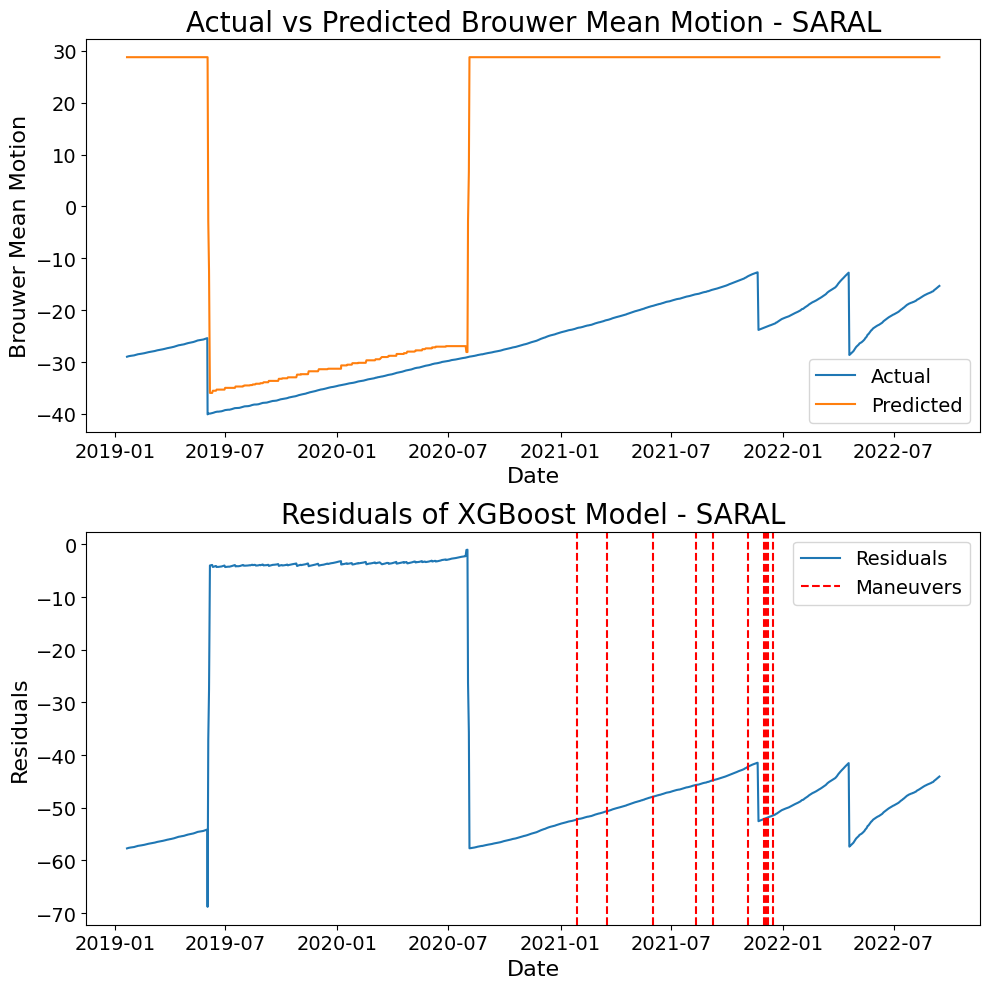

In [25]:
# Generating predictions
predictions = xgb_regressor.predict(df_bmm_x_test)

# Calculating residuals
residuals = df_bmm_y_test['Brouwer mean motion'].to_numpy() - predictions

# Creating a data frame for plotting
df_y_plotting = df_bmm_y_test.copy()
df_y_plotting["residuals"] = residuals
df_y_plotting["predictions"] = predictions

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize = (10,10))

# Plotting actual vs predicted values
sns.lineplot(x = df_bmm_y_test.index, y = df_bmm_y_test["Brouwer mean motion"], label = "Actual", ax = axes[0])
sns.lineplot(x = df_y_plotting.index, y = df_y_plotting["predictions"], label = "Predicted", ax = axes[0])
axes[0].set_title("Actual vs Predicted Brouwer Mean Motion - SARAL", fontsize=20)
axes[0].set_xlabel("Date",fontsize=16)
axes[0].set_ylabel("Brouwer Mean Motion",fontsize=16)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='both',labelsize=14)

# Plotting residuals
sns.lineplot(x = df_y_plotting.index, y = df_y_plotting["residuals"], label = "Residuals", ax = axes[1])
axes[1].set_title("Residuals of XGBoost Model - SARAL", fontsize=20)
axes[1].set_xlabel("Date", fontsize=16)
axes[1].set_ylabel("Residuals", fontsize=16)
axes[1].tick_params(axis='both',labelsize=14)

start_date = pd.to_datetime("2021")
end_date = pd.to_datetime("2022")

# Filtering maneuvers based on the date range
maneuvers_filtered = df[df["Start_Date"] >= start_date]
maneuvers_filtered = maneuvers_filtered[maneuvers_filtered["Start_Date"] <= end_date]

# Marking maneuvers on the residuals plot
maneuver_dates = maneuvers_filtered['Start_Date']
first_label = True
for maneuver_date in maneuver_dates:
    if first_label:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--', label = "Maneuvers")
        first_label = False
    else:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--')     
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

In [16]:
df_y_plotting

,Brouwer mean motion,residuals,predictions
2019-01-20 21:38:53.372832,-28.964154,-57.716124,28.75197
2019-01-21 14:25:01.847712,-28.935753,-57.687724,28.75197
2019-01-22 03:49:56.627616,-28.915217,-57.667187,28.75197
2019-01-23 11:41:36.729024,-28.868465,-57.620435,28.75197
2019-01-24 12:50:49.434432,-28.839627,-57.591597,28.75197
...,...,...,...
2022-09-10 11:47:30.833376,-15.683261,-44.435231,28.75197
2022-09-11 12:56:41.592191,-15.583821,-44.335792,28.75197
2022-09-12 12:25:15.614976,-15.440941,-44.192912,28.75197
2022-09-13 03:30:46.060415,-15.414908,-44.166878,28.75197


In [17]:
# Getting absolute values of the residuals for the anomaly statistic as a series
residuals_series = df_y_plotting["residuals"].sort_values().abs()
residuals_series = pd.Series(residuals_series, index = df_bmm.index)
residuals_series =residuals_series.dropna()
residuals_series

2019-01-20 21:38:53.372832    57.716124
2019-01-21 14:25:01.847712    57.687724
2019-01-22 03:49:56.627616    57.667187
2019-01-23 11:41:36.729024    57.620435
2019-01-24 12:50:49.434432    57.591597
                                ...    
2022-09-10 11:47:30.833376    44.435231
2022-09-11 12:56:41.592191    44.335792
2022-09-12 12:25:15.614976    44.192912
2022-09-13 03:30:46.060415    44.166878
2022-09-14 04:39:56.791584    44.069003
Name: residuals, Length: 1320, dtype: float64

In [18]:
# Getting the maneuver time stamps into a series in date time format
maneuver_dates_series = pd.Series(pd.to_datetime(df.Start_Date))
maneuver_dates_series

0    2016-02-22 09:30:00
1    2016-02-23 10:45:00
2    2016-02-24 19:29:00
3    2016-02-26 09:27:00
4    2016-03-02 12:59:00
             ...        
59   2022-05-18 06:08:00
60   2022-06-14 09:30:00
61   2022-07-21 06:41:00
62   2022-08-25 08:13:00
63   2022-10-06 07:00:00
Name: Start_Date, Length: 64, dtype: datetime64[ns]

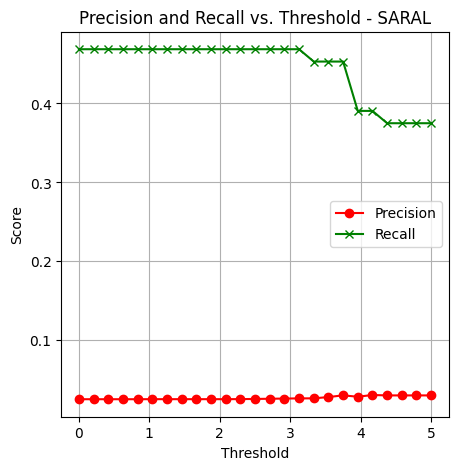

In [19]:
import pandas as pd
import numpy as np

def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

def compute_simple_matching_precision_recall_for_one_threshold(
    float_matching_max_days,
    float_threshold,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    """
    :param float_matching_max_days:
    :param float_threshold:
    :param pd_series_ground_truth_manoeuvre_timestamps:
    :param pd_series_predictions: The index of this series should be the timestamps of the predictions.
    :return: (precision, recall)

   Computes the precision and recall at one anomaly threshold.

   Does this using an implementation of the framework proposed by Zhao:
   Zhao, L. (2021). Event prediction in the big data era: A systematic survey. ACM Computing Surveys (CSUR), 54(5), 1-37.
   https://doi.org/10.1145/3450287

   The method matches each manoeuvre prediction with the closest ground-truth manoeuvre, if it is within a time window.

   Predictions with a match are then true positives and those without a match are false positives. Ground-truth manoeuvres
   with no matching prediction are counted as false negatives.
   """

    matching_max_distance_seconds = pd.Timedelta(days=float_matching_max_days).total_seconds()

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    np_manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(pd_series_ground_truth_manoeuvre_timestamps)
    np_pred_time_stamps_seconds = convert_timestamp_series_to_epoch(pd_series_predictions.index)
    np_predictions = pd_series_predictions.to_numpy()

    for i in range(np_predictions.shape[0]):
        if np_predictions[i] >= float_threshold:
            left_index = np.searchsorted(
                np_manoeuvre_timestamps_seconds, np_pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < pd_series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(np_manoeuvre_timestamps_seconds[left_index] - np_pred_time_stamps_seconds[i])
                > abs(np_manoeuvre_timestamps_seconds[left_index + 1] - np_pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(np_manoeuvre_timestamps_seconds[index_of_closest] - np_pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (
                    index_of_closest,
                    diff,
                )
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    np_positive_prediction_indices = np.argwhere(np_predictions >= float_threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in np_positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(pd_series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives)) if (len(dict_ground_truth_to_predictions) + len(list_false_positives)) > 0 else 0
    recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) if (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) > 0 else 0

    total_negatives = len(np_predictions) - len(pd_series_ground_truth_manoeuvre_timestamps)
    fpr = len(list_false_positives)/total_negatives

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall)/(precision + recall)

    return (precision, recall, fpr, f1_score)

# Create plot with precision and recall values for different thresholds
def plot_precision_recall_against_threshold_curve(threshold_range, precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, precisions, marker='o', label='Precision', color='red')
    plt.plot(threshold_range, recalls, marker='x', label='Recall', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold - SARAL')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculating precision and recall for multiple thresholds
def compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    precisions = []
    recalls = []
    fprs = []
    f1_scores = []

    for threshold in threshold_range:
        precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            threshold,
            pd_series_ground_truth_manoeuvre_timestamps,
            pd_series_predictions,
        )
        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        f1_scores.append(f1_score)

    return precisions, recalls, fprs, f1_scores

if __name__ == "__main__":

    float_matching_max_days = 3
    threshold_range = np.linspace(0,5,25)

    precisions, recalls, fprs, f1_scores = compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    maneuver_dates_series,
    residuals_series,
    )

    plot_precision_recall_against_threshold_curve(threshold_range,precisions,recalls)

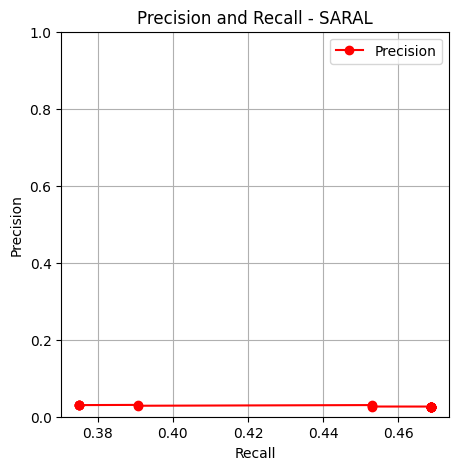

In [20]:
# Create plot with precision and recall
def plot_precision_recall_curve(precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(recalls, precisions, marker = 'o', label='Precision', color='red')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision and Recall - SARAL')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(precisions, recalls)

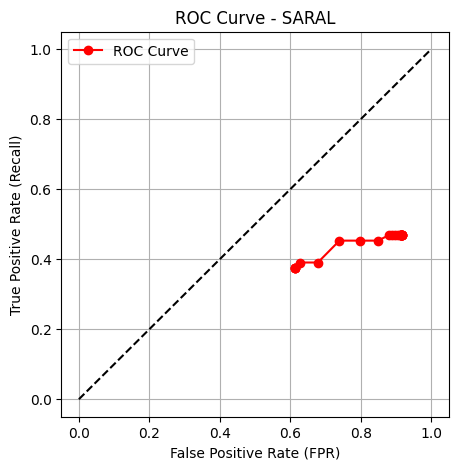

In [21]:
# Create roc plot
def plot_roc_curve(fprs, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(fprs, recalls, marker = 'o', label = 'ROC Curve', color='red')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve - SARAL')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(fprs, recalls)

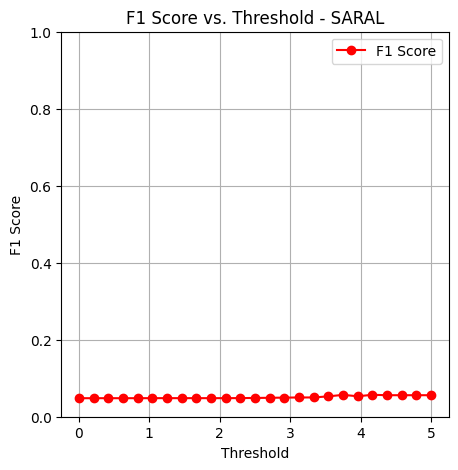

In [22]:
# Create f1_score vs threshold
def plot_f1_score_curve(threshold_range, f1_scores):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, f1_scores, marker = 'o', label = 'F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold - SARAL')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_score_curve(threshold_range, f1_scores)

In [23]:
# Finding the max f1 score and the relevant threshold
max_index = np.argmax(f1_scores)
max_val = f1_scores[max_index]
max_val_threshold = threshold_range[max_index]

print(max_val)
print(max_val_threshold)

0.056947608200455586
4.166666666666667


In [24]:
# Finding the precision and recall for max f1 score
precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            max_val_threshold,
            maneuver_dates_series,
            residuals_series,
        )

print(precision)
print(recall)

0.030712530712530713
0.390625
